<a href="https://colab.research.google.com/github/gunjanak/Siamese-Network/blob/main/Siamese_Network_triplet_loss_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Dataset

In [ ]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
#Creating some helper functions
def imshow(img,text=None):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text,style='italic',fontweight='bold',
             bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

#plotting data
def show_plot(iteration,loss):
  plt.plot(iteration,loss)
  plt.show()

In [ ]:
class RGBToGrayscale(object):
    def __call__(self, sample):
        return transforms.functional.rgb_to_grayscale(sample)

In [ ]:
class TripletDataset(Dataset):
  def __init__(self,root,transform=None):
    self.root = root
    self.transform = transform
    self.dataset = datasets.ImageFolder(root=self.root,transform=self.transform)
    self.classes = list(set([sample[1] for sample in self.dataset.samples]))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,index):
    anchor,anchor_label = self.dataset[index]

    #Select a positive sample from the same class as the anchor
    positive_candidates = [i for i, label in enumerate(self.dataset.targets) if label == anchor_label]
    positive_index = random.choice(positive_candidates)
    positive,positive_label = self.dataset[positive_index]

    #Select a negative sample from a different class
    negative_candidates = [i for i, label in enumerate(self.dataset.targets) if label != anchor_label]
    negative_index = random.choice(negative_candidates)
    negative,negative_lable = self.dataset[negative_index]

    return anchor,positive, negative




#Load and preprocess data

In [ ]:
#Define a suitable transform for your images
transform = transforms.Compose([
    transforms.Resize((100,100)),
    RGBToGrayscale(),
    transforms.ToTensor(),
])

In [ ]:
#Create a TripletDataset
train_dataset = TripletDataset(root="./data/faces/training/",transform=transform)

In [ ]:
#Create Dataloader
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)

#Define network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# # Define Siamese network architecture
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#       super(SiameseNetwork, self).__init__()

#       #Define the convolutional layers
#       self.conv1 = nn.Conv2d(1,64,kernel_size=5)
#       self.pool1 = nn.MaxPool2d(2,2)
#       self.conv2 = nn.Conv2d(64,128,kernel_size=5)
#       self.pool2 = nn.MaxPool2d(2,2)

#       #Define the fully connected layers
#       self.fc1 = nn.Linear(128*9*9*64,256)
#       self.fc2 = nn.Linear(256,128)

#     def forward_one(self,x):
#       x = self.pool1(F.relu(self.conv1(x)))
#       x = self.pool2(F.relu(self.conv2(x)))
#       print(x.shape)
#       x = x.view(-1,128*9*9*64)
#       x = F.relu(self.fc1(x))
#       x = self.fc2(x)
#       return x

#     def forward(self,anchor,positive,negative):
#       output_anchor = self.forward_one(anchor)
#       output_positive = self.forward_one(positive)
#       output_negative = self.forward_one(negative)
#       return output_anchor, output_positive, output_negative


In [ ]:
#Create a SiameseNetwork
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork,self).__init__()

    #Setting up the sequential of CNN layers
    self.cnn1 = nn.Sequential(
        nn.Conv2d(1,96,kernel_size=11,stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3,stride=2),

        nn.Conv2d(96,256,kernel_size=5,stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,stride=2),

        nn.Conv2d(256,384,kernel_size=3,stride=1),
        nn.ReLU(inplace=True)

    )

    #Setting up the fully connected layers
    self.fc1 = nn.Sequential(
        nn.Linear(384,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,256),
        nn.ReLU(inplace=True),
        nn.Linear(256,2)

    )

  def forward_once(self,x):
    #This function will be called for both images
    #Its output is used to determine the similiarity
    output = self.cnn1(x)
    output = output.view(output.size()[0],-1)
    output = self.fc1(output)
    return output

  def forward(self,input1,input2,input3):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    output3 = self.forward_once(input3)

    return output1,output2,output3



In [ ]:
# Define triplet loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()

In [ ]:
train_loader

In [ ]:
# Initialize Siamese network and triplet loss
siamese_net = SiameseNetwork()
triplet_loss = TripletLoss()

# Define optimizer
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

# Training loop
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siamese_net.to(device)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

#Train

In [ ]:
epoch_loss = []

In [ ]:
for epoch in range(num_epochs):
    for batch in train_loader:
      anchor,positive,negative = batch[0].to(device),batch[1].to(device),batch[2].to(device)
      optimizer.zero_grad()
      output_anchor, output_positive, output_negative = siamese_net(anchor, positive, negative)
      loss = triplet_loss(output_anchor, output_positive, output_negative)
      loss.backward()
      optimizer.step()
    epoch_loss.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    if loss.item()<0.05:
      break


Epoch [1/100], Loss: 0.5660
Epoch [2/100], Loss: 0.3819
Epoch [3/100], Loss: 0.5001
Epoch [4/100], Loss: 0.4658
Epoch [5/100], Loss: 0.3076
Epoch [6/100], Loss: 0.4527
Epoch [7/100], Loss: 0.4217
Epoch [8/100], Loss: 0.2995
Epoch [9/100], Loss: 0.3359
Epoch [10/100], Loss: 0.3638
Epoch [11/100], Loss: 0.3018
Epoch [12/100], Loss: 0.3466
Epoch [13/100], Loss: 0.2338
Epoch [14/100], Loss: 0.1807
Epoch [15/100], Loss: 0.0615
Epoch [16/100], Loss: 0.1710
Epoch [17/100], Loss: 0.1880
Epoch [18/100], Loss: 0.2808
Epoch [19/100], Loss: 0.0940
Epoch [20/100], Loss: 0.1172
Epoch [21/100], Loss: 0.2767
Epoch [22/100], Loss: 0.1482
Epoch [23/100], Loss: 0.1887
Epoch [24/100], Loss: 0.0971
Epoch [25/100], Loss: 0.1156
Epoch [26/100], Loss: 0.2102
Epoch [27/100], Loss: 0.3004
Epoch [28/100], Loss: 0.1165
Epoch [29/100], Loss: 0.0905
Epoch [30/100], Loss: 0.1255
Epoch [31/100], Loss: 0.1604
Epoch [32/100], Loss: 0.2060
Epoch [33/100], Loss: 0.0771
Epoch [34/100], Loss: 0.1095
Epoch [35/100], Loss: 0

In [ ]:
epoch_loss

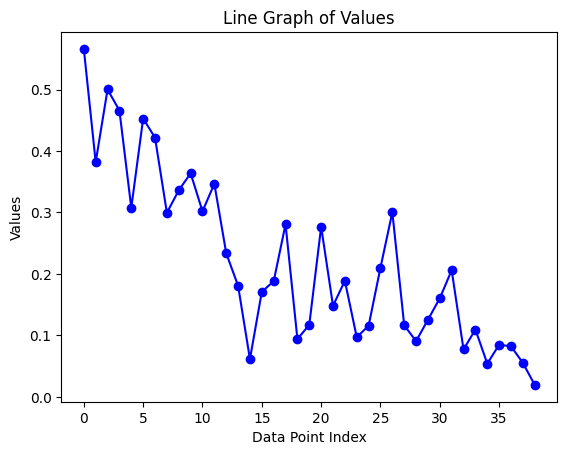

In [ ]:
# Plotting the values as a line graph
plt.plot(epoch_loss, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Line Graph of Values')

# Display the plot
plt.show()